In [48]:
import os
import textwrap
import tiktoken
import matplotlib.pyplot as plt
import numpy as np
import umap.umap_ as umap
import pandas as pd
from langchain.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_openai import ChatOpenAI
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import PyPDFLoader
from langchain.document_loaders import DirectoryLoader
from langchain import PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.runnables import RunnableParallel
from langchain_core.output_parsers import StrOutputParser
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from dotenv import load_dotenv, find_dotenv
from typing import Optional

In [26]:
load_dotenv(find_dotenv())
embeddings = OpenAIEmbeddings()

detailed_turbo_llm = turbo_llm = ChatOpenAI(
    temperature=0,
    model_name='gpt-3.5-turbo-0125'
)

turbo_llm = ChatOpenAI(
    temperature=0.5,
    model_name='gpt-3.5-turbo-0125'
)

# Eliminar la primera página o portada del doc.

In [27]:
# Carga de documentos y extracción de información
# (asegúrate de que haya PDFs en la carpeta documentos)
documents = DirectoryLoader('./documentos/', glob="./*.pdf", loader_cls=PyPDFLoader).load()
# Tratameinto de caracteres indeseados
for d in documents:
    d.page_content = d.page_content.replace('\n', ' ').replace('\t', ' ')
# Separador de texto (límita el texto para que sea soportado por el LLM)
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=3000,
    chunk_overlap=500
)
docs = text_splitter.split_documents(documents)
texts = [doc.page_content for doc in docs]

In [28]:
def num_tokens_from_string(string: str) -> int:
    encoding = tiktoken.get_encoding("cl100k_base")
    num_tokens = len(encoding.encode(string))
    return num_tokens

counts = [num_tokens_from_string(t) for t in texts]

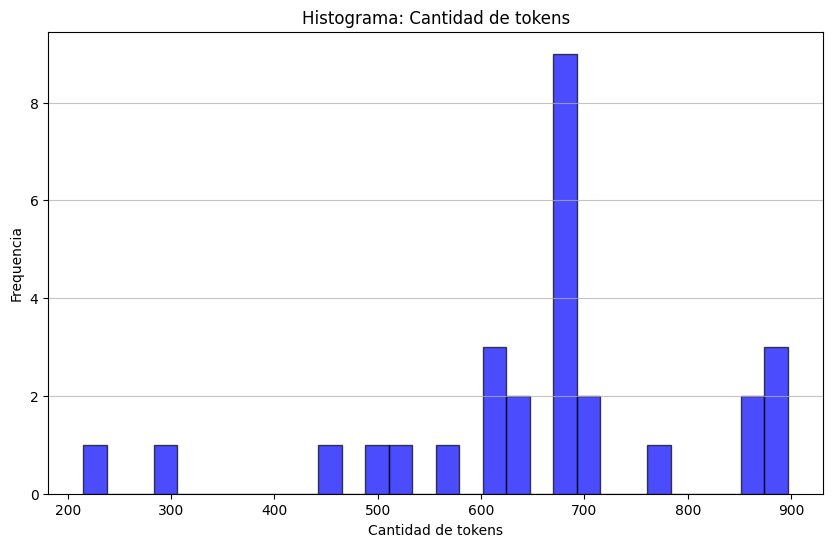

In [29]:
plt.figure(figsize=(10, 6))
plt.hist(counts, bins=30, color="blue", edgecolor="black", alpha=0.7)
plt.title("Histograma: Cantidad de tokens")
plt.xlabel("Cantidad de tokens")
plt.ylabel("Frequencia")
plt.grid(axis="y", alpha=0.75)
plt.show()

In [30]:
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)
print(
    "Num tokens in all context: %s"
    % num_tokens_from_string(concatenated_content)
)

Num tokens in all context: 18462


In [31]:
global_embeddings = [embeddings.embed_query(txt) for txt in texts]

In [32]:
def reduce_cluster_embeddings(
    embeddings: np.ndarray,
    dim: int,
    n_neighbors: Optional[int] = None,
    metric: str = "cosine",
) -> np.ndarray:
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)
    return umap.UMAP(
        n_neighbors=n_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)

dim = 2
global_embeddings_reduced = reduce_cluster_embeddings(global_embeddings, dim)

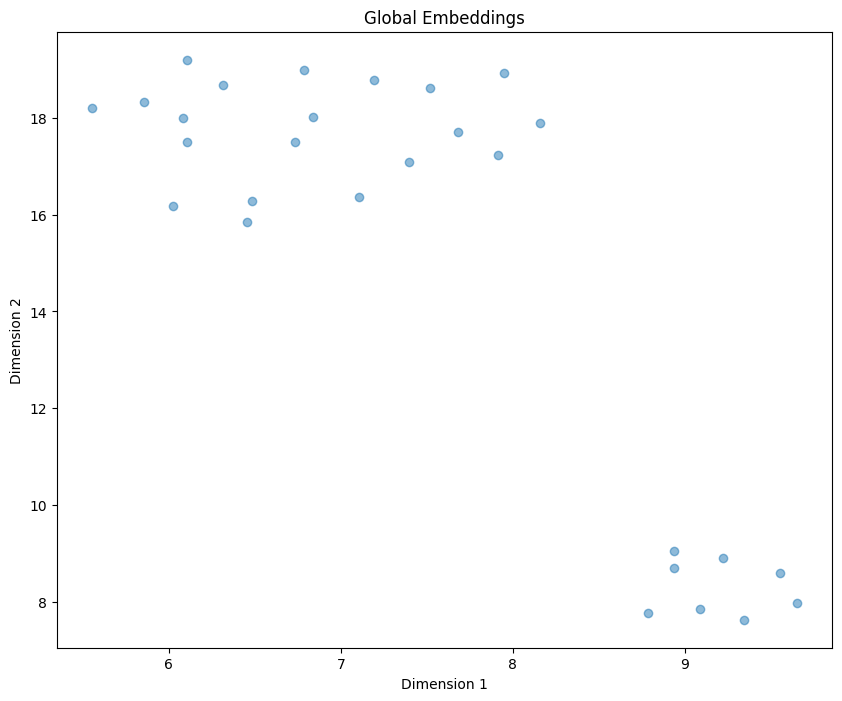

In [33]:
plt.figure(figsize=(10, 8))
plt.scatter(global_embeddings_reduced[:, 0], global_embeddings_reduced[:, 1], alpha=0.5)
plt.title("Global Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

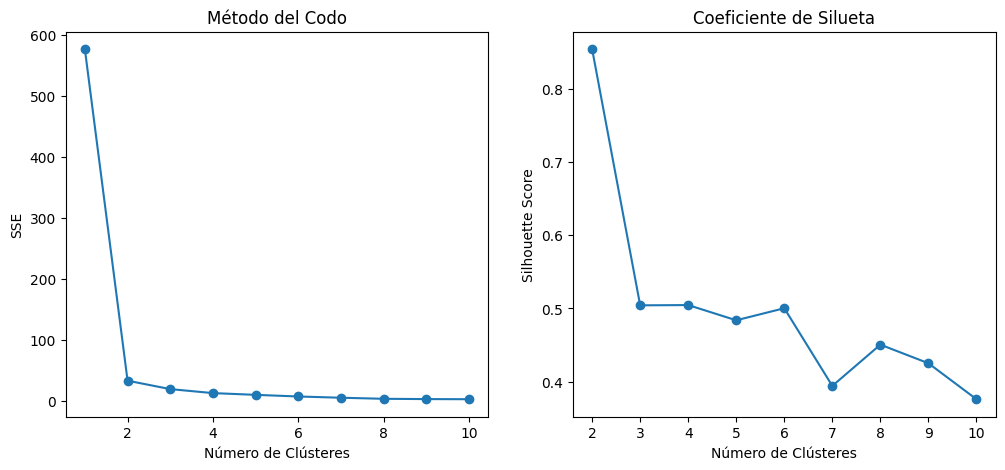

In [34]:
# Método del Codo
sse = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(global_embeddings_reduced)
    sse.append(kmeans.inertia_)

# Coeficiente de Silueta
silhouette_scores = []
for k in k_values[1:]:  # Silhouette score no está definido para k=1
    kmeans = KMeans(n_clusters=k, random_state=0).fit(global_embeddings_reduced)
    score = silhouette_score(global_embeddings_reduced, kmeans.labels_)
    silhouette_scores.append(score)

# Graficar el método del codo
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_values, sse, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clústeres')
plt.ylabel('SSE')

# Graficar el coeficiente de silueta
plt.subplot(1, 2, 2)
plt.plot(k_values[1:], silhouette_scores, marker='o')
plt.title('Coeficiente de Silueta')
plt.xlabel('Número de Clústeres')
plt.ylabel('Silhouette Score')

plt.show()

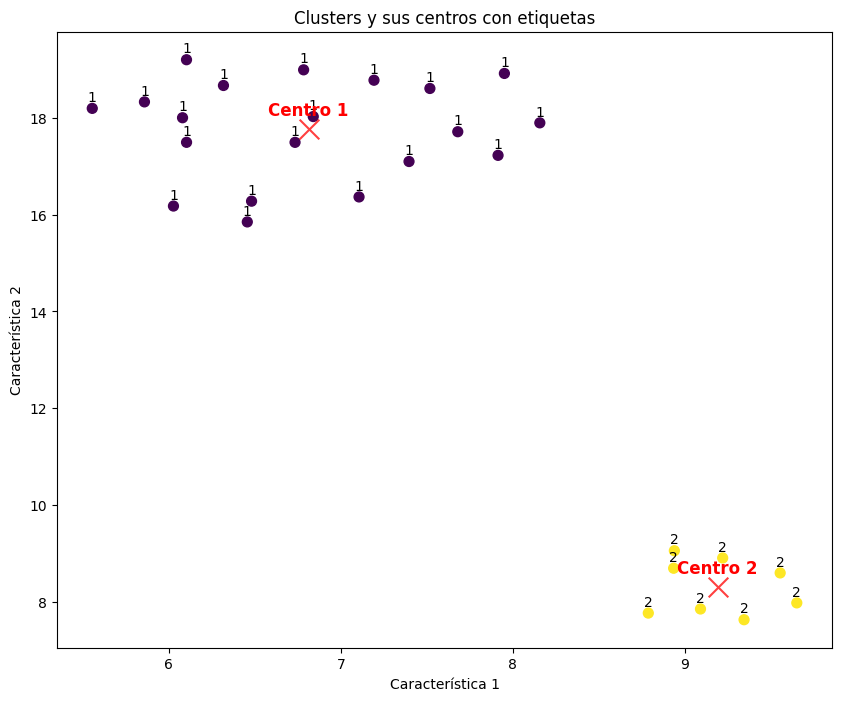

In [35]:
# Suponiendo que 'global_embeddings_reduced' ya está definido
optimal_k = 2

kmeans = KMeans(n_clusters=optimal_k, random_state=0).fit(global_embeddings_reduced)
labels = kmeans.labels_ + 1  # Agregar 1 a las etiquetas de los clústeres
centers = kmeans.cluster_centers_

# Visualizar los datos y los centros de los clústeres
plt.figure(figsize=(10, 8))
plt.scatter(global_embeddings_reduced[:, 0], global_embeddings_reduced[:, 1], c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='x')

# Añadir etiquetas a los puntos de datos
for i in range(len(global_embeddings_reduced)):
    plt.annotate(str(labels[i]), (global_embeddings_reduced[i, 0], global_embeddings_reduced[i, 1]),
                 textcoords="offset points", xytext=(0,5), ha='center')

# Añadir etiquetas a los centros de los clústeres
for i, center in enumerate(centers):
    plt.annotate(f'Centro {i+1}', (center[0], center[1]), textcoords="offset points", xytext=(0,10), ha='center', color='red', fontsize=12, weight='bold')

plt.title("Clusters y sus centros con etiquetas")
plt.xlabel("Característica 1")
plt.ylabel("Característica 2")
plt.show()

# Aplicar análisis a base de datos para determinar de qué habla (tema principal) cada clúster.

In [36]:
df = pd.DataFrame({
    'Texto': texts,
    'Embedding': list(global_embeddings_reduced),
    'Cluster': labels
})
df.head()
doc_nom = input('Ingrese el nombre del documento')
df.to_csv(f'{doc_nom}.csv', sep=';', encoding='utf-8-sig')

In [37]:
def format_cluster_texts(df):
    clustered_texts = {}
    for cluster in df['Cluster'].unique():
        cluster_texts = df[df['Cluster'] == cluster]['Texto'].tolist()
        clustered_texts[cluster] = " --- ".join(cluster_texts)
    return clustered_texts

clustered_texts = format_cluster_texts(df)
clustered_texts

{2: 'pensamiento y gestión, N.° 50 ISSN 2145-941X (online)Políticas, innovación abierta e  internacionalización en pymes Policies, Open Innovation and  Internationalization in SMEs Rubén Darío Echeverri Romero ruben.echeverry@correounivalle.edu.co Economista por Universidad del Valle y magíster en Ciencias Econó - micas por la Universidad Católica de Lovaina. Docente e investigador  de la Universidad del Valle. Leidi Ruano-Arcos leidi.ruano@correounivalle.edu.co Administradora de empresas por la Universidad del Valle y magíster  en Ciencias de la Organización por la Universidad. Docente de la Uni - versidad del Valle. Sara Isabel Bolaños Delgado sara.bolanos@correounivalle.edu.co Socióloga de la Universidad del Valle y Especialista en gerencia de  Marketing Estratégico de la Universidad del Valle . --- 260 pensamiento & gestión, 50. Universidad del Norte, 246-273, 2021Rubén Darío Echeverri Romero, Leidi Ruano-Arcos, Sara Isabel Bolaños Delgadorelación del valor del conocimiento de la a

# Hay que volver a hacer un split de texto para solucionar problemas de capacidad en el LLM.

In [38]:
template = """Eres un asistente capaz de crear resúmenes detallados del texto proporcionado.

Texto:
{text}
"""

prompt = PromptTemplate.from_template(template)
chain = prompt | detailed_turbo_llm | StrOutputParser()

In [39]:
summaries = {}
for cluster, text in clustered_texts.items():
    summary = chain.invoke({"text": text})
    summaries[cluster] = summary

summaries

{2: 'El artículo aborda el tema de las políticas, la innovación abierta y la internacionalización en las pymes. Se menciona la importancia de la relación entre el valor del conocimiento de la alta dirección y las prácticas de creación de conocimiento en la influencia del rendimiento de la organización. Se presentan los 10 artículos más citados entre 2018 y 2020 sobre innovación abierta en el sector de las pymes, destacando la importancia de la colaboración y la apertura en la innovación.\n\nSe sugiere la realización de estudios cuantitativos para una muestra más grande de empresas que permitan formular hipótesis y tener resultados extrapolables para la gestión de la innovación abierta en las pymes. Se menciona la necesidad de realizar análisis longitudinales en lugar de análisis transversales para profundizar en la innovación abierta como promotor de la internacionalización de las pymes.\n\nSe destaca que la mayoría de las investigaciones se han desarrollado en pymes de economías desar

In [40]:
clustered_summaries = {}
for label, summary in zip(labels, summaries.values()):
    if label not in clustered_summaries:
        clustered_summaries[label] = []
    clustered_summaries[label].append(summary)

clustered_summaries

{2: ['El artículo aborda el tema de las políticas, la innovación abierta y la internacionalización en las pymes. Se menciona la importancia de la relación entre el valor del conocimiento de la alta dirección y las prácticas de creación de conocimiento en la influencia del rendimiento de la organización. Se presentan los 10 artículos más citados entre 2018 y 2020 sobre innovación abierta en el sector de las pymes, destacando la importancia de la colaboración y la apertura en la innovación.\n\nSe sugiere la realización de estudios cuantitativos para una muestra más grande de empresas que permitan formular hipótesis y tener resultados extrapolables para la gestión de la innovación abierta en las pymes. Se menciona la necesidad de realizar análisis longitudinales en lugar de análisis transversales para profundizar en la innovación abierta como promotor de la internacionalización de las pymes.\n\nSe destaca que la mayoría de las investigaciones se han desarrollado en pymes de economías desa

In [41]:
final_summaries = {}
for cluster, texts in clustered_summaries.items():
    combined_text = ' '.join(texts)
    summary = chain.invoke({"text": combined_text})
    final_summaries[cluster] = summary

final_summaries

{2: 'El artículo aborda las políticas, la innovación abierta y la internacionalización en las pymes, destacando la importancia de la relación entre el conocimiento de la alta dirección y las prácticas de creación de conocimiento en el rendimiento de la organización. Se presentan los 10 artículos más citados sobre innovación abierta en las pymes, resaltando la colaboración y la apertura en la innovación.\n\nSe sugiere la realización de estudios cuantitativos con muestras más grandes para formular hipótesis y obtener resultados extrapolables para la gestión de la innovación abierta en las pymes. Se menciona la importancia de realizar análisis longitudinales para profundizar en la innovación abierta como promotor de la internacionalización de las pymes.\n\nSe destaca que la mayoría de las investigaciones se han realizado en pymes de economías desarrolladas, mientras que en países como China y en el contexto latinoamericano los estudios son escasos. Se plantean recomendaciones para futuras

In [42]:
texts_from_df = df['Texto'].tolist()
texts_from_clustered_texts = list(clustered_texts.values())
texts_from_final_summaries = list(final_summaries.values())

combined_texts = texts_from_df + texts_from_clustered_texts + texts_from_final_summaries

In [76]:
combined_texts[:10]

['pensamiento y gestión, N.° 50 ISSN 2145-941X (online)Políticas, innovación abierta e  internacionalización en pymes Policies, Open Innovation and  Internationalization in SMEs Rubén Darío Echeverri Romero ruben.echeverry@correounivalle.edu.co Economista por Universidad del Valle y magíster en Ciencias Econó - micas por la Universidad Católica de Lovaina. Docente e investigador  de la Universidad del Valle. Leidi Ruano-Arcos leidi.ruano@correounivalle.edu.co Administradora de empresas por la Universidad del Valle y magíster  en Ciencias de la Organización por la Universidad. Docente de la Uni - versidad del Valle. Sara Isabel Bolaños Delgado sara.bolanos@correounivalle.edu.co Socióloga de la Universidad del Valle y Especialista en gerencia de  Marketing Estratégico de la Universidad del Valle .',
 'Fecha de recepción: 29 de septiembre de 2020 Fecha de aceptación: 10 de abril  de 2021Resumen Este artículo exploró la innovación abierta en las pymes y abordó el con - cepto desde las polí

# Guardar los kb en una carpeta (kbs)

### 1. Enseñar

In [43]:
persist_directory = input('¿Cómo se llama este knoledge-base?: ') + '_kb'
vectorstore = Chroma.from_texts(texts=combined_texts,
                                embedding=embeddings,
                                persist_directory=persist_directory)
vectorstore.persist()
vectorstore = None
os.system(f'zip -r db.zip ./{persist_directory}')

1

### 2. Recordar (si y solo si Enseñar=Done) y pregunta de control

In [44]:
persist_directory = input('¿Qué knoledge-base deseas usar?: ') + '_kb'
embedding = OpenAIEmbeddings()
vectorstore = Chroma(persist_directory=persist_directory, 
                  embedding_function=embedding)

def adjust_final_number(string: str, max_threshold: int, initial_number: int) -> int:
    final_number = initial_number
    while final_number < max_threshold:
        retriever = vectorstore.as_retriever(search_kwargs={"k": final_number})
        docs = retriever.invoke(string)
        text = "".join([doc.page_content for doc in docs])
        if num_tokens_from_string(text) < max_threshold:
            final_number += 1
        else:
            break
    return final_number

final_number = adjust_final_number("¿Cuál es el tema pricipal del documento?", 10000, 4)
print(final_number)
retriever = vectorstore.as_retriever(search_kwargs={"k": final_number})

4


In [49]:
# Se personaliza el LLM
template = """
Eres Prometeo, un asistente personal de revisión biliográfica que habla Español.

Tu tarea consiste en:

1. Leer detalladamente la información proporcionada en documentos que generalmente son
artículos científicos en formato PDF.

2. Proporcionar respuestas extremadamente detalladas a cualquier tipo de pregunta relacionada 
con el contexto, especialmente a preguntas específicas. Evita concluir tus respuestas con un 
párrafo que comience con 'En resumen,...'. Varía las conclusiones de tus respuestas para que 
sean más diversas y creativas.

3. Ser carismático y ofrecer información sobre ti y tus funciones.

SIEMPRE debes responder con base al contexto proporcionado aqui: {context}.
        
Si no sabes la respuesta, puedes decir: 'No sé'.

NUNCA hables específicamente del contexto.

NUNCA terminar las respuestas con un resumen o una conclusión predecible.

Teniendo en cuenta TODO lo anterior, responde la siguiente pregunta: {question}
"""

prometeo_prompt = PromptTemplate(
    template=template, input_variables=["context", "question"]
)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = (
    RunnablePassthrough.assign(context=(lambda x: format_docs(x["context"])))
    | prometeo_prompt
    | turbo_llm
    | StrOutputParser()
)

rag_chain_with_source = RunnableParallel(
    {"context": retriever, "question": RunnablePassthrough()}
).assign(answer=rag_chain
)

In [67]:
def wrap_text_preserve_newlines(text, width=70):
    lines = text.split('\n')
    wrapped_lines = [textwrap.fill(line, width=width) for line in lines]
    wrapped_text = '\n'.join(wrapped_lines)
    return wrapped_text

def process_llm_response(llm_response):
    print(wrap_text_preserve_newlines(llm_response['answer']))
    print('\nReferencias:')
    for contexto in llm_response["context"]:
        print(contexto)

In [68]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain_with_source.invoke(query)
process_llm_response(llm_response)

¿Cuáles son los principales resultados de la investigación?
Los principales resultados de la investigación incluyen el análisis de
las revistas más productivas en el campo de la innovación abierta en
las pymes, la identificación de los autores más influyentes, el
análisis de las palabras clave utilizadas en los estudios, y la
relación entre la innovación abierta, las políticas de innovación y la
internacionalización en las pymes. Se destaca la importancia de la
colaboración, el emprendimiento, la capacidad de absorción, la gestión
estratégica de la tecnología, y la gestión de la innovación abierta
como factores clave en el desempeño de las empresas. Además, se
resalta la necesidad de investigar más sobre la relación entre la
innovación abierta y la internacionalización, así como de explorar
cómo las políticas públicas pueden influir en la adopción de la
innovación abierta en las pymes y su impacto en la expansión
internacional.

Referencias:
page_content='254 pensamiento & gestión, 50.

# Hacer historial